In [1]:
import numpy as np
import random
import warnings
import random
import copy
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sb

In [2]:
class Individuo:
    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 verbose=False):
        self.n_variables = n_variables
        self.limites_inf = limites_inf
        self.limites_sup = limites_sup
        self.valor_variables = np.repeat(None, n_variables)
        self.fitness = None
        self.valor_funcion = None
        
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf, np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)
        
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " + 
                "cuales debe buscarse la solución de cada variable. " + 
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )

        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)
            
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3
           
        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3
        
        for i in np.arange(self.n_variables):
            self.valor_variables[i] = random.uniform(
                                        self.limites_inf[i],
                                        self.limites_sup[i]
                                      )

        if verbose:
            print("Nuevo individuo creado")
            print("----------------------")
            print("Valor variables: " + str(self.valor_variables))
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("Límites inferiores de cada variable: " \
                  + str(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + str(self.limites_sup))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto individuo.

        """

        texto = "Individuo" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Valor variables: " + str(self.valor_variables) \
                + "\n" \
                + "Valor función objetivo: " + str(self.valor_funcion) \
                + "\n" \
                + "Fitness: " + str(self.fitness) \
                + "\n" \
                + "Límites inferiores de cada variable: " \
                + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " \
                + str(self.limites_sup) \
                + "\n"

        return(texto)

    def calcular_fitness(self, funcion_objetivo, optimizacion, verbose = False):
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: 'maximizar' o 'minimizar'"
                )

        self.valor_funcion = funcion_objetivo(*self.valor_variables)
        if optimizacion == "maximizar":
            self.fitness = self.valor_funcion
        elif optimizacion == "minimizar":
            self.fitness = -self.valor_funcion

        if verbose:
            print("El individuo ha sido evaluado")
            print("-----------------------------")
            print("Valor función objetivo: " + str(self.valor_funcion))
            print("Fitness: " + str(self.fitness))
            print("")

    def mutar(self, prob_mut=0.01, distribucion="uniforme", media_distribucion=1,
              sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
              verbose=False):
        if not distribucion in ["normal", "uniforme", "aleatoria"]:
            raise Exception(
                "El argumento distribucion debe ser: 'normal', 'uniforme' o " \
                + "'aleatoria'"
                )

        posiciones_mutadas = np.random.uniform(
                                low=0,
                                high=1,
                                size=self.n_variables
                             )
        posiciones_mutadas = posiciones_mutadas < prob_mut

        if distribucion in ["normal", "uniforme"]:
            if distribucion == "normal":
                factor_mut = np.random.normal(
                                loc   = media_distribucion,
                                scale = sd_distribucion,
                                size  = np.sum(posiciones_mutadas)
                             )
            if distribucion == "uniforme":
                factor_mut = np.random.uniform(
                                low  = min_distribucion,
                                high = max_distribucion,
                                size = np.sum(posiciones_mutadas)
                             )
            self.valor_variables[posiciones_mutadas] = \
                self.valor_variables[posiciones_mutadas] + factor_mut

            for i in np.flatnonzero(posiciones_mutadas):
                if self.valor_variables[i] < self.limites_inf[i]:
                    self.valor_variables[i] = self.limites_inf[i]
                if self.valor_variables[i] > self.limites_sup[i]:
                    self.valor_variables[i] = self.limites_sup[i]

        if distribucion == "aleatoria":
            for i in np.flatnonzero(posiciones_mutadas):
                self.valor_variables[i] = random.uniform(
                                            self.limites_inf[i],
                                            self.limites_sup[i]
                                          )

        self.fitness = None
        self.valor_funcion = None

        if verbose:
            print("El individuo ha sido mutado")
            print("---------------------------")
            print("Total mutaciones: " + str(np.sum(posiciones_mutadas)))
            print("Valor variables: " + str(self.valor_variables))
            print("")

In [3]:
class Poblacion:
    def __init__(self, n_individuos, n_variables, limites_inf=None,
                 limites_sup=None, verbose=False):

        self.n_individuos = n_individuos
        self.n_variables = n_variables
        self.limites_inf = limites_inf
        self.limites_sup = limites_sup
        self.individuos = []
        self.optimizado = False
        self.iter_optimizacion = None
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_funcion = None
        self.mejor_valor_variables = None
        self.historico_individuos = []
        self.historico_mejor_valor_variables = []
        self.historico_mejor_fitness = []
        self.historico_mejor_valor_funcion = []
        self.diferencia_abs = []
        self.resultados_df = None
        self.fitness_optimo = None
        self.valor_variables_optimo = None
        self.valor_funcion_optimo = None

        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        for i in np.arange(n_individuos):
            individuo_i = Individuo(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup,
                            verbose     = verbose
                          )
            self.individuos.append(individuo_i)

        if verbose:
            print("----------------")
            print("Población creada")
            print("----------------")
            print("Número de individuos: " + str(self.n_individuos))
            print("Límites inferiores de cada variable: " \
                  + np.array2string(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + np.array2string(self.limites_sup))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto población.

        """

        texto = "============================" \
                + "\n" \
                + "         Población" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de individuos: " + str(self.n_individuos) \
                + "\n" \
                + "Límites inferiores de cada variable: " + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " + str(self.limites_sup) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización (generaciones): " \
                     + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información del mejor individuo:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Valor variables: " + str(self.mejor_valor_variables) \
                + "\n" \
                + "Fitness: " + str(self.mejor_fitness) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "--------------------------" \
                + "\n" \
                + "Valor óptimo de variables: " + str(self.valor_variables_optimo) \
                + "\n" \
                + "Valor óptimo función objetivo: " + str(self.valor_funcion_optimo) \
                + "\n" \
                + "Fitness óptimo: " + str(self.fitness_optimo)
                
                
        return(texto)

    def mostrar_individuos(self, n=None):
        if n is None:
            n = self.n_individuos
        elif n > self.n_individuos:
            n = self.n_individuos

        for i in np.arange(n):
            print(self.individuos[i])
        return(None)

    def evaluar_poblacion(self, funcion_objetivo, optimizacion, verbose=False):
        for i in np.arange(self.n_individuos):
            self.individuos[i].calcular_fitness(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose
            )

        self.mejor_individuo = copy.deepcopy(self.individuos[0])
        for i in np.arange(self.n_individuos):
            if self.individuos[i].fitness > self.mejor_individuo.fitness:
                self.mejor_individuo = copy.deepcopy(self.individuos[i])

        self.mejor_fitness = self.mejor_individuo.fitness
        self.mejor_valor_variables = self.mejor_individuo.valor_variables
        self.mejor_valor_funcion = self.mejor_individuo.valor_funcion
        
        if verbose:
            print("------------------")
            print("Población evaluada")
            print("------------------")
            print("Mejor fitness encontrado : " + str(self.mejor_fitness))
            print("Valor de la función objetivo: " \
                + str(self.mejor_valor_funcion))
            print("Mejor valor de variables encontrado : "
                + str(self.mejor_valor_variables))
            print("")

    def cruzar_individuos(self, parental_1, parental_2, verbose=False):

        if parental_1 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_1 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )
        if parental_2 not in np.arange(self.n_individuos):
            raise Exception(
                "El el índice del parental_2 debe de ser un valor entre 0 y " +
                "el número de individuos de la población."
                )

        parental_1 = self.individuos[parental_1]
        parental_2 = self.individuos[parental_2]
        
        descendencia = copy.deepcopy(parental_1)
        descendencia.valor_variables = np.repeat(None, descendencia.n_variables)
        descendencia.fitness = None

        herencia_parent_1 = np.random.choice(
                                a       = [True, False],
                                size    = descendencia.n_variables,
                                p       = [0.5, 0.5],
                                replace = True
                            )
        herencia_parent_2 = np.logical_not(herencia_parent_1)

        descendencia.valor_variables[herencia_parent_1] \
            = parental_1.valor_variables[herencia_parent_1]

        descendencia.valor_variables[herencia_parent_2] \
            = parental_2.valor_variables[herencia_parent_2]
        

        descendencia = copy.deepcopy(descendencia)

        if verbose:
            print("---------------")
            print("Cruce realizado: descendencia creada")
            print("---------------")
            print("Valor variables: " + str(descendencia.valor_variables))
            print("")
        return(descendencia)
    
    def seleccionar_individuo(self, n, return_indices=True,
                              metodo_seleccion="tournament", verbose=False):

        if metodo_seleccion not in ["ruleta", "rank", "tournament"]:
            raise Exception(
                "El método de selección debe de ser ruleta, rank o tournament"
                )

        array_fitness = np.repeat(None, self.n_individuos)
        for i in np.arange(self.n_individuos):
            array_fitness[i] = copy.copy(self.individuos[i].fitness)
        
        if metodo_seleccion == "ruleta":
            probabilidad_seleccion = array_fitness / np.sum(array_fitness)
            ind_seleccionado = np.random.choice(
                                    a       = np.arange(self.n_individuos),
                                    size    = n,
                                    p       = list(probabilidad_seleccion),
                                    replace = True
                               )
        elif metodo_seleccion == "rank":
            order = np.flip(np.argsort(a=array_fitness) + 1)
            ranks = np.argsort(order) + 1
            probabilidad_seleccion = 1 / ranks
            probabilidad_seleccion = probabilidad_seleccion / np.sum(probabilidad_seleccion)
            ind_seleccionado = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = n,
                                p       = list(probabilidad_seleccion),
                                replace = True
                            )
        elif metodo_seleccion == "tournament":
            ind_seleccionado = np.repeat(None,n)
            for i in np.arange(n):
                # Se seleccionan aleatoriamente dos parejas de individuos.
                candidatos_a = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                candidatos_b = np.random.choice(
                                a       = np.arange(self.n_individuos),
                                size    = 2,
                                replace = False
                            )
                # De cada pareja se selecciona el de mayor fitness.
                if array_fitness[candidatos_a[0]] > array_fitness[candidatos_a[1]]:
                    ganador_a = candidatos_a[0]
                else:
                    ganador_a = candidatos_a[1]

                if array_fitness[candidatos_b[0]] > array_fitness[candidatos_b[1]]:
                    ganador_b = candidatos_b[0]
                else:
                    ganador_b = candidatos_b[1]

                # Se comparan los dos ganadores de cada pareja.
                if array_fitness[ganador_a] > array_fitness[ganador_b]:
                    ind_final = ganador_a
                else:
                    ind_final = ganador_b
                
                ind_seleccionado[i] = ind_final

        if verbose:
            print("---------------")
            print("Individuo seleccionado")
            print("---------------")
            print("Método selección: " + metodo_seleccion)
            print("")

        if(return_indices):
            return(ind_seleccionado)
        else:
            if n == 1:
                return(copy.deepcopy(self.individuos[int(ind_seleccionado)]))
            if n > 1:
                return(
                    [copy.deepcopy(self.individuos[i]) for i in ind_seleccionado]
                )
            
    def crear_nueva_generecion(self, metodo_seleccion="tournament",
                               elitismo=0.1, prob_mut=0.01,
                               distribucion="uniforme",
                               media_distribucion=1, sd_distribucion=1,
                               min_distribucion=-1, max_distribucion=1,
                               verbose=False, verbose_seleccion=False,
                               verbose_cruce=False, verbose_mutacion=False):

        nuevos_individuos = []

        if elitismo > 0:
            n_elitismo = int(np.ceil(self.n_individuos*elitismo))
            array_fitness = np.repeat(None, self.n_individuos)
            for i in np.arange(self.n_individuos):
                array_fitness[i] = copy.copy(self.individuos[i].fitness)
            rank = np.flip(np.argsort(array_fitness))
            elite = [copy.deepcopy(self.individuos[i]) for i in rank[:n_elitismo]]
            nuevos_individuos = nuevos_individuos + elite
        else:
            n_elitismo = 0
            
        for i in np.arange(self.n_individuos-n_elitismo):
            # Seleccionar parentales
            indice_parentales = self.seleccionar_individuo(
                                    n                = 2,
                                    return_indices   = True,
                                    metodo_seleccion = metodo_seleccion,
                                    verbose          = verbose_seleccion
                                 )
            
            descendencia = self.cruzar_individuos(
                            parental_1 = indice_parentales[0],
                            parental_2 = indice_parentales[1],
                            verbose    = verbose_cruce
                           )
            
            descendencia.mutar(
                prob_mut         = prob_mut,
                distribucion     = distribucion,
                min_distribucion = min_distribucion,
                max_distribucion = max_distribucion,
                verbose          = verbose_mutacion
            )

            nuevos_individuos = nuevos_individuos + [descendencia]

        self.individuos = copy.deepcopy(nuevos_individuos)
        self.mejor_individuo = None
        self.mejor_fitness = None
        self.mejor_valor_variables = None
        self.mejor_valor_funcion = None
        
        if verbose:
            print("-----------------------")
            print("Nueva generación creada")
            print("-----------------------")
            print("Método selección: " + metodo_seleccion)
            print("Elitismo: " + str(elitismo))
            print("Número individuos élite: " + str(n_elitismo))
            print("Número de nuevos individuos: "\
                + str(self.n_individuos-n_elitismo))
            print("")

    def optimizar(self, funcion_objetivo, optimizacion, n_generaciones = 50,
                  metodo_seleccion="tournament", elitismo=0.1, prob_mut=0.01,
                  distribucion="uniforme", media_distribucion=1,
                  sd_distribucion=1, min_distribucion=-1, max_distribucion=1,
                  parada_temprana=False, rondas_parada=None,
                  tolerancia_parada=None,verbose=False,
                  verbose_nueva_generacion=False,
                  verbose_seleccion=False, verbose_cruce=False,
                  verbose_mutacion=False, verbose_evaluacion=False):

        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        start = time.time()

        for i in np.arange(n_generaciones):
            if verbose:
                print("-------------")
                print("Generación: " + str(i))
                print("-------------")
            
            self.evaluar_poblacion(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose_evaluacion
                )

            self.historico_individuos.append(copy.deepcopy(self.individuos))
            self.historico_mejor_fitness.append(copy.deepcopy(self.mejor_fitness))
            self.historico_mejor_valor_variables.append(
                                    copy.deepcopy(self.mejor_valor_variables)
                                )
            self.historico_mejor_valor_funcion.append(
                                    copy.deepcopy(self.mejor_valor_funcion)
                                )

            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_fitness[i] \
                                 - self.historico_mejor_fitness[i-1])
                self.diferencia_abs.append(diferencia)

            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la generación " 
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " generaciones consecutivas.")
                    break
                   
            self.crear_nueva_generecion(
                metodo_seleccion   = metodo_seleccion,
                elitismo           = elitismo,
                prob_mut           = prob_mut,
                distribucion       = distribucion,
                verbose            = verbose_nueva_generacion,
                verbose_seleccion  = verbose_seleccion,
                verbose_cruce      = verbose_cruce,
                verbose_mutacion   = verbose_mutacion
                )

        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i
        
        indice_valor_optimo  = np.argmax(np.array(self.historico_mejor_fitness))
        self.fitness_optimo  = self.historico_mejor_fitness[indice_valor_optimo]
        self.valor_funcion_optimo = self\
                                    .historico_mejor_valor_funcion[indice_valor_optimo]
        self.valor_variables_optimo = self\
                                      .historico_mejor_valor_variables[indice_valor_optimo]
        
        self.resultados_df = pd.DataFrame(
            {
            "mejor_fitness"        : self.historico_mejor_fitness,
            "mejor_valor_funcion"  : self.historico_mejor_fitness,
            "mejor_valor_variables": self.historico_mejor_valor_variables,
            "diferencia_abs"       : self.diferencia_abs
            }
        )
        self.resultados_df["generacion"] = self.resultados_df.index
        
        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de generaciones: " + str(self.iter_optimizacion))
        print("Valor óptimo de las variables: " + str(self.valor_variables_optimo))
        print("Valor función objetivo: " + str(self.valor_funcion_optimo))
        print("")

In [4]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

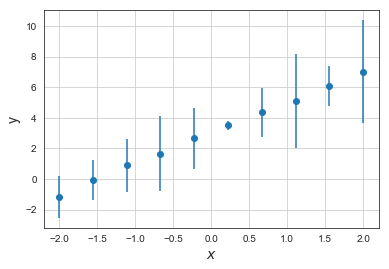

In [5]:
# Entran datos sintéticos
r     = np.linspace(-2, 2 , 10)  
m     = 2
b     = 3

np.random.seed(100)

dispersion = np.random.normal(-0.0, .1,  size=len(r))
function = m*r + b + dispersion
error = np.random.normal(-0.0, 3,  size=len(r))

sb.set_style("white", {'axes.grid': True})
plt.errorbar(r, function , error, fmt='o')
plt.ylabel('y',fontsize=14)
plt.xlabel('$x$',  fontsize=14)
plt.savefig("SinteticData.jpg")
plt.show()

In [6]:
df = pd.DataFrame({'x':r, 'f':function, 'error':error})
df.head()
print(df)

          x         f     error
0 -2.000000 -1.174977 -1.374081
1 -1.555556 -0.076843  1.305490
2 -1.111111  0.893081 -1.750785
3 -0.666667  1.641423  2.450541
4 -0.222222  2.653688  2.018162
5  0.222222  3.495866 -0.313233
6  0.666667  4.355451 -1.593841
7  1.111111  5.115218  3.089198
8  1.555556  6.092162 -1.314407
9  2.000000  7.025500 -3.354955


In [7]:
s= df['error']**2
covariance = pd.DataFrame(np.diag(s),index=s.index,columns=s.index)

In [8]:
def theory(x_0, x_1=2, x_2=3):
    return x_0*x_1 + x_2   

In [9]:
def loglike(x_1=2, x_2=3):
   #m = params[0]
    
    delta = theory(df['x'], x_1, x_2) - df['f']
    chisquare = np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    
    return -chisquare/2.

In [10]:
def funcion_objetivo(x_1, x_2):

    delta = theory(df['x'], x_1, x_2) - df['f']
    chisquare = np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    f=-chisquare/2
    return(f)

In [11]:
poblacion = Poblacion(
                n_individuos = 50,
                n_variables  = 2,
                limites_inf  = [-5,-5],
                limites_sup  = [5,5],
                verbose      = False
            )

poblacion.optimizar(
    funcion_objetivo   = funcion_objetivo,
#    optimizacion       = "minimizar",
    optimizacion       = "maximizar",    
    n_generaciones     = 250,
    metodo_seleccion   = "tournament",
    elitismo           = 0.01,
    prob_mut           = 0.1,
    distribucion       = "uniforme",
    media_distribucion = 1,
    sd_distribucion    = 1,
    min_distribucion   = -1,
    max_distribucion   = 1,
    parada_temprana    = True,
    rondas_parada      = 10,
    tolerancia_parada  = 10**-16,
    verbose            = False
)

Algoritmo detenido en la generación 51 por falta cambio absoluto mínimo de 1e-16 durante 10 generaciones consecutivas.
-------------------------------------------
Optimización finalizada 2020-03-02 13:56:20
-------------------------------------------
Duración optimización: 6.606844186782837
Número de generaciones: 51
Valor óptimo de las variables: [2.0271635568581567 3.035038346462702]
Valor función objetivo: -0.014799277786565392



In [12]:
poblacion

         Población
Número de individuos: 50
Límites inferiores de cada variable: [-5 -5]
Límites superiores de cada variable: [5 5]
Optimizado: True
Iteraciones optimización (generaciones): 51

Información del mejor individuo:
----------------------------
Valor variables: [2.0271635568581567 3.035038346462702]
Fitness: -0.014799277786565392

Resultados tras optimizar:
--------------------------
Valor óptimo de variables: [2.0271635568581567 3.035038346462702]
Valor óptimo función objetivo: -0.014799277786565392
Fitness óptimo: -0.014799277786565392

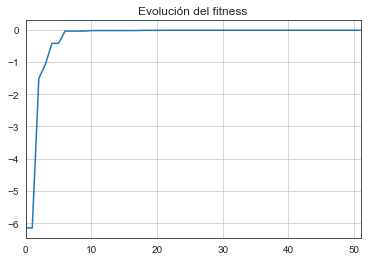

In [13]:
# Evolución de la optimización
poblacion.resultados_df['mejor_fitness'].plot(title = "Evolución del fitness")